## 关于《流浪地球》炸裂的口碑，机器学习竟然是这样评价的……
### ————Python文本情感极性分析详解

* NLP（神经语言程序学/自然语言学习）是当前机器学习领域一个重要的分支，就是用机器学习模型来理解处理人类的自然语言，并给出符合自然语言逻辑的反馈。
* 自然语言学习中具体的工作包括，教会程序用算法来正确地提取句子的主体成分（分词），判断句子的情感色彩（情感分析）等，并基于此实现文本分类，语言翻译，自动回复等更高级功能。
* 此文尝试建立多种NLP模型，并利用《流浪地球》影评评语作为样本数据进行训练，对比模型（情感词典模型，机器学习模型（词向量模型、MLP/多层感知机））之间的相同和差异。

## 一、 基于情感词典的文本情感极性分析
*  通过情感打分的方式进行文本情感极性判断。
* score > 0判断为正向，score < 0判断为负向。

### 1、数据准备

#### 备用情感分析文档
* 常用情感词典：词典来源于BosonNLP数据下载的情感词典 BosonNLP_sentiment_score.txt
* 否定词词典，（自己手动构建）构建常见否定词词典  negwords_70.txt
* 程度副词词典：《知网》情感分析用词语集（beta版）（自己手动为词打分）degreeDict.txt
* 中文停用词  stopwords_1208.txt

#### 情感分析词文档可以去各自专业网站下载  
* 为统一文件的读取格式，所有文件均已用utf-8编码格式存储

#### 程度副词词典打分（手动添加）标准：
* “极其|extreme / 最|most”级别 ---2.00
* “很|very”级别 --- 1.75
* “较|more”级别 --- 1.50
* “稍|-ish”级别 --- 1.20
* “欠|insufficiently”级别 --- 0.50
* “超|over”级别 --- -1.00

In [1]:
# 读取样本数据信息,流浪地球_影评01.txt为随机抽取的样本
sens = []
with open('流浪地球_影评01.txt','r',
          encoding='utf-8-sig') as f:
    datas = f.readlines()
    
    for data in datas:
        sen = data.strip()
        sens.append(sen)
print(len(sens))

524


In [2]:
# 获取停用词列表
with open('files/stopwords_1208.txt','r',
          encoding='utf-8-sig') as f:
   stopwords = f.readlines()
print(len(stopwords))

1208


### 2、数据获取与清洗
* 获取电影影评文件
* 获取停用词文件
* 详细代码参见《267019猫眼数据加持，原来你是这样的<流浪地球>
* ——python数据分析全流程代码实现！（一）》 数据清洗部分
* github源代码地址：https://github.com/Willsgao/Personal-projects

In [3]:
# 定义句子分词函数
def sent2word(sentence,stopwords):
    # 句子分词处理
    segList = jieba.cut(sentence)
    words = []
    for word in segList:
        if word not in stopwords:
            words.append(word) 
    return words

### 3、构建情感词典模型

#### 3.1 将词语进行分类和定位

In [10]:
# 导入中文分词相关工具包
from collections import defaultdict
import os, re, codecs
import jieba
import matplotlib.pyplot as mp

In [5]:
# 构建分词分类模型（情感定位）
def classifyWords(words): 
    # (1) 情感词,备用情感词文件存储在files文件夹里
    senDict = defaultdict()
    with open('files/BosonNLP_sentiment_score.txt', 'r', 
              encoding='utf-8-sig') as f:
        senList = f.readlines()
    # 用评语和评分标签（二分）构建字典
    for st in senList:
        sen = st.strip().split(' ')
        if len(sen) <2:
            continue
        senDict[sen[0]] = sen[1]
    
    # (2) 否定词,files[1]为备用否定词文件名
    with open('files/negwords_70.txt', 'r',
              encoding='utf-8-sig') as f:
        negLists = f.readlines()
        # 否定词处理
        negList = []
        for neg in negLists:
            neg = neg.strip()
            if not neg:
                continue
            negList.append(neg)

    # (3) 程度副词,files[2]为备用程度副词文件名
    with open('files/degreeDict.txt','r',
              encoding='utf-8-sig') as f:
        degreeList = f.readlines()
    degreeDict = defaultdict()
    for dg in degreeList:
        degree = dg.strip().split('\t')
        degreeDict[degree[0]] = degree[1]

    
    # 情感词处理
    senWord = defaultdict()
    negWord = defaultdict()
    degreeWord = defaultdict()
    
    # 细化分词的词性感情色彩特征
    for idx,wd in enumerate(words):
        if wd in senDict.keys() and wd not in\
        negList and wd not in degreeDict.keys():
            senWord[idx] = senDict[wd]
        elif wd in negList and wd not in degreeDict.keys():
            negWord[idx] = -1
        elif wd in degreeDict.keys():
            degreeWord[idx] = degreeDict[wd]
    
    return senWord, negWord, degreeWord

#### 3.2 计算句子感情色彩得分
* 在此，简化的情感分数计算逻辑：所有情感词语组的分数之和
* 得分公式：单句最后得分sen_score =  (-1)^(negWord数量)x(degreeWord数量)x(句子得分)
* 总分合计：final_score = sum(sen_score)

In [6]:
# 定义情感得分函数
def scoreSent(senWord, negWord, degreeWord, words):
    W = 1
    score = 0
    # 存储所有情感词位置的列表
    senLoc = list(senWord.keys())
    negLoc = list(negWord.keys())
    degreeLoc = list(degreeWord.keys())
    senloc = -1
    
    # 遍历句子中所有单词的segResult,i为单词的绝对位置
    for i in range(len(words)):
        # 如果该词为情感词
        if i in senLoc:
            # loc 为情感词位置列表的序号
            senloc += 1
            # 直接添加该情感词分数
            score += W * float(senWord[i])
            # print("score = %f"% score)
            if senloc < len(senLoc) - 1:
                # 判断该情感词与下一情感词之间是否存在否定词或程度副词
                # j为绝对位置
                for j in range(senLoc[senloc], senLoc[senloc+1]):
                    # 如果含有否定词
                    if j in negLoc:
                        W *= -1
                    # 如果含有程度副词
                    elif j in degreeLoc:
                        W *= float(degreeWord[j])
    return score

####  3.3 样本预处理
* 将样本数据进行预处理，满足格式要求

In [8]:
# 对样本进行分词处理
scores = []
for sentence in sens:
    words = sent2word(sentence,stopwords)
    senWord, negWord, degreeWord = \
    classifyWords(words)
    score = scoreSent(senWord, 
                      negWord, degreeWord, words)
    # 为排除句子长度（分词个数）对分值的影响，进行归一化处理
    score /= len(words)
    scores.append(score)
print(len(scores))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Python\AppData\Local\Temp\jieba.cache
Loading model cost 0.821 seconds.
Prefix dict has been built succesfully.


524


### 4、数据可视化
* 对坐标数据进行归一化处理
* 绘制趋势变化散点图

In [9]:
# 以得分作为纵坐标，顺序值作为横坐标画散点图
import numpy as np
x = []
y = []
scores = sorted(scores)
min_score = min(scores)
max_score = max(scores)
wid = max_score - min_score
for idx,score in enumerate(scores):
    x.append(idx)
    y.append(float((score-min_score)/wid))
x = np.array(x)
y = np.array(y)

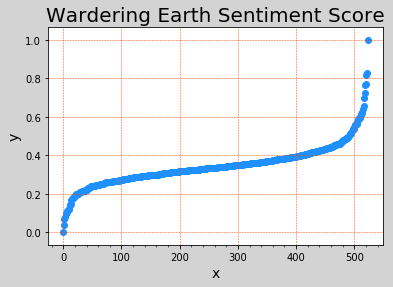

In [11]:
# 可视化代码
mp.figure('Wardering Earth Sentiment Score', facecolor='lightgray')
mp.title('Wardering Earth Sentiment Score', fontsize=20)
mp.xlabel('x', fontsize=14)
mp.ylabel('y', fontsize=14)
ax = mp.gca()
ax.xaxis.set_minor_locator(
    mp.MultipleLocator(20))
ax.yaxis.set_minor_locator(
    mp.MultipleLocator())
ax.grid(which='major', axis='both', linewidth=0.5,
        linestyle='--', color='orangered')
mp.scatter(x, y, c='dodgerblue')
mp.show()

### 5、情感词典模型小结
* 1、两级的评价感情色彩比较强烈，尤其是夸赞一方；
* 即使经过归一化处理仍能看出与均值偏差加大。
* 2、受极值范围影响，主体评价部分评语得分较为和缓；
* 不能准确形象地反映总体观众对电影的评价结果。
* 3、对于正负向文本的判断，该算法忽略了很多其他的否定词、程度副词
* 和情感词搭配的情况；用于判断情感强弱也过于简单。
* 4、关于y轴得分与星级评价的关系需要结合具体业务分析，此处暂不处理。
### 该模型只能作为基础定性的评价模型

## 二、基于机器学习的文本情感极性分析
* 基于词向量Word2Vec建立机器学习模型

### 1、模型数学抽象
* 本文构建模型的目的是进行文本（影评）情感色彩识别，属于分类问题。
* NLP处理涉及分词（中文分词器:jieba,loso,smallseg等），选择jieba工具包。
* 建立机器学习模型涉及标签分类，选择SVM和MLP模型。

In [12]:
# 导入相关基础工具包
import sys
import numpy as np 
import pandas as pd
import jieba
import matplotlib.pyplot as mp

### 2、数据准备
* 停用词准备与一中相同

In [13]:
# 获取停用词列表
with open('files/stopwords_1208.txt','r',
          encoding='utf-8-sig') as f:
   stopwords = f.readlines()

#### 2.1 读取数据

In [14]:
# 读取合并后的文件信息
datas = pd.read_csv('合并文件/流浪地球01_comments.csv',
                encoding='utf_8_sig',engine='python')
# 查看数据的基本信息属性
datas.describe()

,昵称,城市,评语,评分,日期,性别标签
count,267014,266354,266994,266974,266968,141429
unique,239386,1061,247327,12,190455,3
top,.,北京,好看好看好看,5.0,2019-02-07 00:00:00,1.0
freq,379,8615,972,188289,16,89518


#### 2.2 数据清洗处理
* 为方便计算，将评分不小于2.5分的归为“正评”，小于2.5分的归为“负评”。
* 将数据分为训练集和测试集

In [15]:
# 读取评语和评分数据
all_com_scores =  datas.loc[:,['评语','评分']]
# 将评分为空的数据删除
com_scores = all_com_scores.dropna(axis=0)
print(com_scores.shape)
# print(com_scores.head())

(266974, 2)


In [16]:
# 将评分值归类
com_scores['评分'].replace(['5.0','4.5','4.0','3.5','3.0','2.5',
                       '2.0','1.5','1.0','0.5','0.0'],
                      ['正评','正评','正评','正评','正评','正评',
                       '负评','负评','负评','负评','负评'],inplace=True)
print(len(com_scores))

# 将正负评化的数据保存，以备后续读取
com_scores.to_csv('流浪地球_comment_scores.txt',
                  sep='\t',index=False,header=None)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


266974


In [17]:
# 将正负评价分开存储
neg_cs = com_scores.ix[com_scores['评分'] == '负评']
pos_cs = com_scores.ix[com_scores['评分'] == '正评']

neg_cs.to_csv('neg_score01.txt',sep='\t',index=False,header=None)
pos_cs.to_csv('pos_score01.txt',sep='\t',index=False,header=None)
print(len(neg_cs))
print(len(pos_cs))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


10078
256885


### 3、数据处理
* 为简化运行，随机抽取了9088条'负评'样本为“负评’训练样本
* 随机抽取了9058条'正评'样本为“正评’训练样本

#### 3.1 定义分词器函数

In [18]:
# 定义句子分词函数，并去除停用词
def sent2word(sentence,stopwords):
    # 句子分词处理
    segList = jieba.cut(sentence)
    words = []
    # 去除停用词
    for word in segList:
        if word not in stopwords:
            words.append(word) 
    # 剩余分词重新组合
    output = '  '.join(words)
    return output

#### 3.2 定义数据处理函数

In [19]:
# 获取词向量转化函数
def getWordVecs(wordList,model):
    vecs = []
    for word in wordList:
        word = word.replace('\n', '')
        try:
            vecs.append(model[word])
        except KeyError:
            continue
    # vecs = np.concatenate(vecs)
    return np.array(vecs, dtype = 'float')

# 建立词向量
def buildVecs(filename,model):
    posInput = []
    with open(filename,'r', encoding='utf-8-sig') as f:
        for line in f.readlines():
            line = line.strip().split('\t')[0]
            line_spl = jieba.cut(line)
            resultList = getWordVecs(line_spl,model)
            # for each sentence, the mean vector of all its vectors is used to represent this sentence
            if len(resultList) != 0:
                resultArray = sum(np.array(resultList))/len(resultList)
                posInput.append(resultArray)

    return posInput

#### 3.3 获取目标词汇文件

In [20]:
sens = []
with open("流浪地球_影评01.txt", 'r', 
          encoding='utf-8-sig') as f:
    for sent in f.readlines():
        sent = sent.strip()
        sen_out = sent2word(sent,stopwords)
        sens.append(sen_out)

# 将目标数据保存为所需格式
sens = pd.DataFrame(sens)
sens.to_csv("文本分析/流浪地球_corpus.csv", mode='a', encoding='utf_8_sig',
                  index=False, sep=',', header=False)

### 4、Word2vec数据词向量化

#### 4.1 机器模型相关工具包

In [21]:
# 机器模型相关工具包
import gensim.models.word2vec as w2v
import sklearn.cross_validation as scv
import sklearn.externals.joblib as sej
import sklearn.preprocessing as sp
import sklearn.svm as ss
import sklearn.decomposition as sd
import sklearn.metrics as sm

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### 4.2 生成目标文件词向量备用文档

In [24]:
#模型训练，生成词向量
sentences = w2v.LineSentence("文本分析/流浪地球_corpus.csv") 
model = w2v.Word2Vec(sentences, size=20, window=5, min_count=5, workers=4) 
model.save("文本分析/corpus01.model")

#### 4.3 模型样本词向量化

In [26]:
# 分别读取正评价和副评价文档内容
posInput = buildVecs('train_pos.txt',model)
negInput = buildVecs('train_neg.txt',model)

# 0（副评价），1（正评价）初始化评价词向量空间
y = np.concatenate(
    (np.ones(len(posInput)), 
     np.zeros(len(negInput))))

X = posInput[:]

for neg in negInput:
    X.append(neg)
X = np.array(X)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


#### 4.4 样本数据标准化

In [27]:
# 将样本数据进行标准化处理
X = sp.scale(X)

### 5、主成分分析
* 可视化主成分影响因素
* 进行适当的PCA降维处理

#### 5.1 可视化主成分因素

[8.77963915e-01 5.38628259e-02 2.41470197e-02 2.24467601e-02
 1.01364023e-02 3.97908638e-03 2.46819636e-03 1.66338788e-03
 7.93160631e-04 6.35487217e-04 4.82235819e-04 3.00335012e-04
 2.70323102e-04 2.03246751e-04 1.93847461e-04 1.83500780e-04
 1.18836750e-04 6.86973576e-05 5.49518261e-05 2.77840093e-05]


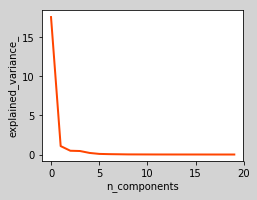

In [32]:
# 创建主成分分析变量
pca = sd.PCA()
pca.fit(X)

# 主成分分析可视化
mp.figure(1, figsize=(4, 3),facecolor='lightgray')
mp.clf()
mp.axes([.2, .2, .7, .7])
mp.plot(pca.explained_variance_, linewidth=2, c='orangered')
mp.axis('tight')
mp.xlabel('n_components')
mp.ylabel('explained_variance_')

# 查看主成分变量方差占比
print(pca.explained_variance_ratio_)

#### PCA可视化小结
* 从主成分图像和主成分变量方差占比矩阵可知：
* 前5个成分占比之和在总成分中有绝对优势，选择前5个特征进行降维

#### 5.2 PCA降维

In [33]:
# 根据PCA（主成分分析）建议选择5个主成分特征
X_reduced = sd.PCA(n_components = 5).fit_transform(X)

# 随机抽取 10% 的数据作为测试集，其余为训练集 
X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = \
    scv.train_test_split(X_reduced,y,test_size=0.10,random_state=0)

# 查看训练集、测试集的维度
print('X训练集维度:',X_reduced_train.shape,'X测试集维度:',X_reduced_test.shape)
print('y训练集维度:',y_reduced_train.shape,'y测试集维度:',y_reduced_test.shape)

X训练集维度: (16193, 5) X测试集维度: (1800, 5)
y训练集维度: (16193,) y测试集维度: (1800,)


### 6、SVM(支持向量机)模型预测

#### 6.1 模型的创建、训练和预测

In [34]:
# 建立支持向量机模型进行训练、预测
clf = ss.SVC(C = 2, probability = True)
clf.fit(X_reduced_train, y_reduced_train)

pred_probas = clf.predict_proba(X_reduced_test)[:,1]

# 模型预测准确率
print('Test Accuracy: %.2f'% 
      clf.score(X_reduced_test, y_reduced_test))

Test Accuracy: 0.63


#### 6.2 模型的可视化评估
* 绘制学习模型的ROC曲线图，对模型进行可视化并评估

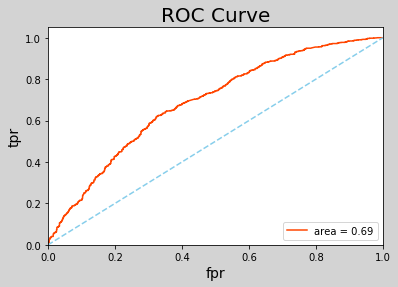

In [35]:
# 获取测试集预测的假阳性率和真阳性率
fpr,tpr,_ = sm.roc_curve(y_reduced_test, pred_probas)
# 获取ROC曲线下面积值
roc_auc = sm.auc(fpr,tpr)

# 绘制接受者操作特征曲线（ROC Curve）
mp.figure('ROC Curve',facecolor='lightgray')
mp.title('ROC Curve',fontsize=20)
mp.xlabel('fpr',fontsize=14)
mp.ylabel('tpr',fontsize=14)
mp.plot(fpr, tpr, label = 'area = %.2f' % roc_auc,c='orangered')
mp.plot([0, 1], [0, 1], 'k--',c='skyblue')
mp.xlim([0.0, 1.0])
mp.ylim([0.0, 1.05])
mp.legend(loc = 'lower right')
mp.show()

#### SVM学习模型小结
* 模型的数据预测准确率为0.63，差强人意
* ROC曲线可知曲线下面积为0.69(取值区间为0.5-1),预测效果较为勉强

### 7、MLP（多层感知机）模型
* 利用keras工具包

#### 7.1 导入相关工具包

In [36]:
# 导入MLP相关工具包
import tensorflow as tf
import keras.models as km
from keras.layers import Dense, Dropout, Activation

Using TensorFlow backend.


#### 7.2 模型的创建

In [37]:
# 建立多层感知机模型
model = km.Sequential()

model.add(Dense(512, input_dim = 20, init = 'uniform', activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=20, activation="tanh", kernel_initializer="uniform")`
  after removing the cwd from sys.path.


#### 7.3 模型的训练和预测

In [38]:
# 获取训练集和预测集（与SVM模型共用）
X_train, X_test, y_train, y_test = scv.train_test_split(
    X,y,test_size=0.10,random_state=0)

model.fit(X_train, y_train, nb_epoch = 20, batch_size = 16)
score = model.evaluate(X_test, y_test, batch_size = 16)
print ('Test accuracy: ', score[1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/20
16193/16193 [==============================] - 6s 364us/step - loss: 0.6990 - acc: 0.5479
Epoch 2/20
16193/16193 [==============================] - 5s 292us/step - loss: 0.6725 - acc: 0.5990
Epoch 3/20
16193/16193 [==============================] - 5s 297us/step - loss: 0.6466 - acc: 0.6358
Epoch 4/20
16193/16193 [==============================] - 5s 317us/step - loss: 0.6339 - acc: 0.6540
Epoch 5/20
16193/16193 [==============================] - 5s 320us/step - loss: 0.6201 - acc: 0.6739
Epoch 6/20
16193/16193 [==============================] - 5s 301us/step - loss: 0.6049 - acc: 0.6927
Epoch 7/20
16193/16193 [==============================] - 5s 310us/step - loss: 0.5978 - acc: 0.6973
Epoch 8/20
16193/16193 [==============================] - 5s 299us/step - loss: 0.5915 - acc: 0.7026
Epoch 9/20
16193/16193 [==============================] - 5s 301us/step - loss: 0.5904 - acc: 0.7050
Epoch 10/20
16193/16193 [==============================] - 5s 304us/step - loss: 0.5809 - a

#### 7.4 模型的可视化评估
* 绘制ROC曲线
* 评估模型的预测性能

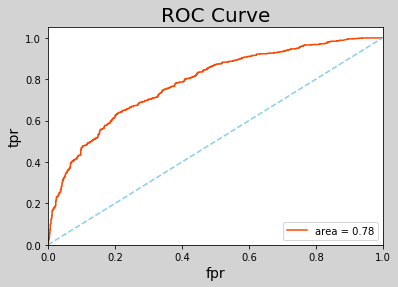

In [39]:
pred_probas = model.predict(X_test)

# 获取测试集预测的假阳性率和真阳性率
fpr,tpr,_ = sm.roc_curve(y_reduced_test, pred_probas)
# 获取ROC曲线下面积值
roc_auc = sm.auc(fpr,tpr)

# 绘制接受者操作特征曲线（ROC Curve）
mp.figure('ROC Curve',facecolor='lightgray')
mp.title('ROC Curve',fontsize=20)
mp.xlabel('fpr',fontsize=14)
mp.ylabel('tpr',fontsize=14)
mp.plot(fpr, tpr, label = 'area = %.2f' % roc_auc,c='orangered')
mp.plot([0, 1], [0, 1], 'k--',c='skyblue')
mp.xlim([0.0, 1.0])
mp.ylim([0.0, 1.05])
mp.legend(loc = 'lower right')
mp.show()

#### MLP学习模型小结
* 模型的数据预测准确率为0.70，较SVM有较明显性能提升
* ROC曲线可知曲线下面积为0.78(取值区间为0.5-1),预测效果提升明显

## 三、模型性能评估
* 1、相比于基于词典的情感分析方法，基于机器学习的方法更为客观
* 2、在文本情感预测方面，MLP(多层感知机)模型性能较SVM(支持向量机)更好
* 3、由于项目自身的问题(样本数据与文本标签的选择等)，模型的预测能力还不完美，需要做进一步性能优化